In [4]:
#import the necessary libraries
import pandas as pd
import os
import seaborn as sns


Here, I'll build a model to predict pitcher wins. This would be the kind of feature that I want to use as I account for and predict what stats are important for building a good fantasy team. This is just a preliminary demonstration.

In [5]:
#take a look at what we have to explore
!ls

AllstarFull.csv               Managers.csv
Appearances.csv               ManagersHalf.csv
AwardsManagers.csv            Parks.csv
AwardsPlayers.csv             People.csv
AwardsShareManagers.csv       Pitching.csv
AwardsSharePlayers.csv        PitchingPost.csv
Batting.csv                   Salaries.csv
BattingPost.csv               Schools.csv
CollegePlaying.csv            SeriesPost.csv
Fielding.csv                  Teams.csv
FieldingOF.csv                TeamsFranchises.csv
FieldingOFsplit.csv           TeamsHalf.csv
FieldingPost.csv              predicting_pitcher_wins.ipynb
HallOfFame.csv                readme2014.txt
HomeGames.csv


In [6]:
#import the pitchers data and take a look at it
pitchers = pd.read_csv('Pitching.csv')
pitchers.tail()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,...,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
45801,youngch03,2017,1,KCA,AL,0,0,14,2,0,...,2.0,1,1.0,0,148.0,5,27,0.0,0.0,3.0
45802,zastrro01,2017,1,CHN,NL,0,0,4,0,0,...,0.0,0,1.0,0,62.0,0,13,0.0,0.0,3.0
45803,zieglbr01,2017,1,MIA,NL,1,4,53,0,0,...,6.0,1,6.0,0,211.0,21,29,3.0,0.0,10.0
45804,zimmejo02,2017,1,DET,AL,8,13,29,29,0,...,2.0,3,7.0,0,713.0,0,111,3.0,8.0,19.0
45805,zychto01,2017,1,SEA,AL,6,3,45,0,0,...,3.0,1,5.0,1,173.0,7,12,1.0,2.0,5.0


In [23]:
#look at what all the features we have are
pitchers.columns

Index(['playerID', 'yearID', 'stint', 'teamID', 'lgID', 'W', 'L', 'G', 'GS',
       'CG', 'SHO', 'SV', 'IPouts', 'H', 'ER', 'HR', 'BB', 'SO', 'BAOpp',
       'ERA', 'IBB', 'WP', 'HBP', 'BK', 'BFP', 'GF', 'R', 'SH', 'SF', 'GIDP'],
      dtype='object')

In [36]:
#I want to predict wins, so I set my target as the Wins column in our data frame
y = pitchers.W

#I then delete the Wins column because I don't want to train on the data I'm trying to predict
del pitchers['W']
pitchers.fillna(0)

#I want to get one-hot variables for categorical things like League and Team
#but if I leave the PlayerID in there, I will have thousands of one-hot columns that are meaningless
#it will make the data take too long to work with and doesn't add anything (that I can think of)
del pitchers['playerID']
#now that I have deleted
one_hot = pd.get_dummies(pitchers)


In [37]:
#we're going to need to validate our model, so let's use the train_test_split function
#here we import the necessary function
from sklearn.model_selection import train_test_split

#let's take a look at the columns again to make sure we didn't create way too many one-hot dummy variables
one_hot.columns

Index(['yearID', 'stint', 'L', 'G', 'GS', 'CG', 'SHO', 'SV', 'IPouts', 'H',
       ...
       'teamID_WS7', 'teamID_WS8', 'teamID_WS9', 'teamID_WSU', 'lgID_AA',
       'lgID_AL', 'lgID_FL', 'lgID_NL', 'lgID_PL', 'lgID_UA'],
      dtype='object', length=181)

In [38]:
#split the dataset 80/20 for training/testing
X_train, X_test, y_train, y_test = train_test_split(one_hot, y, test_size = .2, random_state=42)


In [39]:
#import the necessary library to create our model
from xgboost import XGBRegressor

#define the model. I arbitrarily selected the number of trees to fit and the learning rate
model = XGBRegressor(n_estimators=124, learning_rate=0.05)


In [40]:
#fit the model
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=124,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [42]:
#make predictions about the test set
predictions = model.predict(X_test)

#we want to know how well we predicted number of wins, so we will import a function to measure mean absolute error.
from sklearn.metrics import mean_absolute_error
print("MAE is "+ str(mean_absolute_error(predictions, y_test)))

MAE is 1.1135217059298754


In [46]:
#if we're predicting within about 1 game, that's a pretty good prediction.
#let's see if we can make it better with more trees

estim = [100,150,200,250,300,350]
lrs = [0.005, 0.01, 0.05, 0.1]
for num in estim:
    for lr in lrs:
        model = XGBRegressor(n_estimators=num, learning_rate=lr)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print("MAE is "+ str(mean_absolute_error(predictions, y_test)))

MAE is 2.863752402799459
MAE is 1.9979518873316573
MAE is 1.1351495600474035
MAE is 1.070456321278245
MAE is 2.363627120013243
MAE is 1.5638966722158958
MAE is 1.093505686360841
MAE is 1.0509768749748456
MAE is 2.0011811579478618
MAE is 1.3558994526654657
MAE is 1.0737698770127582
MAE is 1.0402742041963282
MAE is 1.7453338602853379
MAE is 1.2571272953150965
MAE is 1.061709391634242
MAE is 1.036213462229406
MAE is 1.5655714268345833
MAE is 1.2068773532207813
MAE is 1.0534068274298913
MAE is 1.0321441693835267
MAE is 1.4424967050122997
MAE is 1.1789399568748589
MAE is 1.0487031088115295
MAE is 1.0301027851082878


In [1]:
#Obviously, there's room for improvement. We improved from 1.113 to 1.093
#Oops! I realized that my test set is only the most recent 
#we always kept going down, so it seems we haven't overfit
# lrs = [0.1, 0.5, 1.0]
# estim = [350,400,450]

# for num in estim:
#     for lr in lrs:
#         model = XGBRegressor(n_estimators=num, learning_rate=lr)
#         model.fit(X_train, y_train)
#         predictions = model.predict(X_test)
#         print("MAE is "+ str(mean_absolute_error(predictions, y_test)))

In [50]:
lrs = [0.1]
estim = [400,450,500,550]

for num in estim:
    for lr in lrs:
        model = XGBRegressor(n_estimators=num, learning_rate=lr)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        print("MAE is "+ str(mean_absolute_error(predictions, y_test)))

MAE is 1.0280941753499608
MAE is 1.0270967173657024
MAE is 1.0256665427041767
MAE is 1.0250265147358901


In [ ]:
#the model started getting worse when we went up to 0.5 with the learning rate
#so we'll stick with 0.1 - we could narrow this down farther
#but this is a primarily academic exercise at this point


In [2]:
import seaborn as sns


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


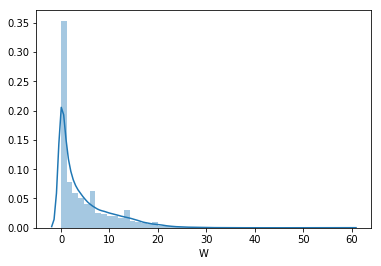

In [7]:
sns.distplot(pitchers.W)
#The distribution of wins, a notoriously difficult to predict category

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


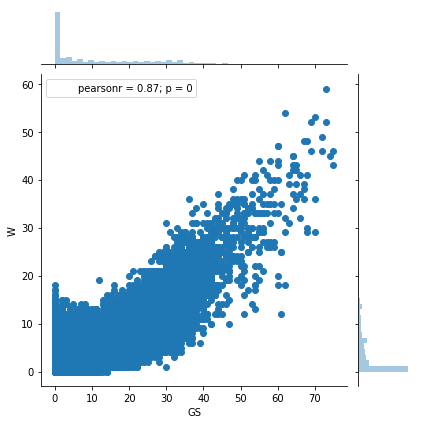

In [10]:
sns.jointplot(pitchers.GS, pitchers.W)
#obviously, wins is going to be correlated with the number of games started
#you can't get a win unless you start a game